### In this notebook, we will explore the following questions: 
 - Is there a relationship between the number of installs and the number of user ratings? Does it matter if we consider a different range in the number of installs?
 - Are apps 'getting better'? Are the ratings and the number of reviews higher for newer apps? 
     
 - ##### Are there trends in the number of user ratings for each developer? (Namely, if a developer publishes a "popular" app, do their subsequent apps become more popular due to the increased recognition/exposure?)

In [725]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import ipywidgets as widgets
import re
from datetime import datetime
import calendar 

In [726]:
sns.set()

In [727]:
apps = pd.read_csv(r'Google Play Store Apps.zip')
apps.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [728]:
apps.shape

(2312944, 24)

In [729]:
# Drop invalid entry and irrelevant columns to current analysis
columns = ['Category', 'Minimum Android', 'Developer Email', 'Last Updated', 'Developer Website', 'Developer Email', 
           'Content Rating', 'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice', 'Scraped Time']
apps.drop(columns=columns, inplace=True)

In [730]:
apps.dropna(subset=['Installs', 'Rating Count'], inplace=True)

In [731]:
# Remove the '+' at the end of the Installs entry so they can be numerically sorted 
# Also remove the ',' separating the numbers
apps['Installations'] = apps['Installs'].str.replace(r'\+|,', '')
apps['Installations'] = apps['Installations'].astype(int)

<ipython-input-731-68a00ffdbcd3>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  apps['Installations'] = apps['Installs'].str.replace(r'\+|,', '')


Let's see a distrubtion of the number of installations. 

In [732]:
grouped_installs = apps.groupby(by=['Installs', 'Installations']).count()
grouped_installs.reset_index(inplace=True)

In [733]:
grouped_installs.sort_values(by=['Installations'], inplace=True)

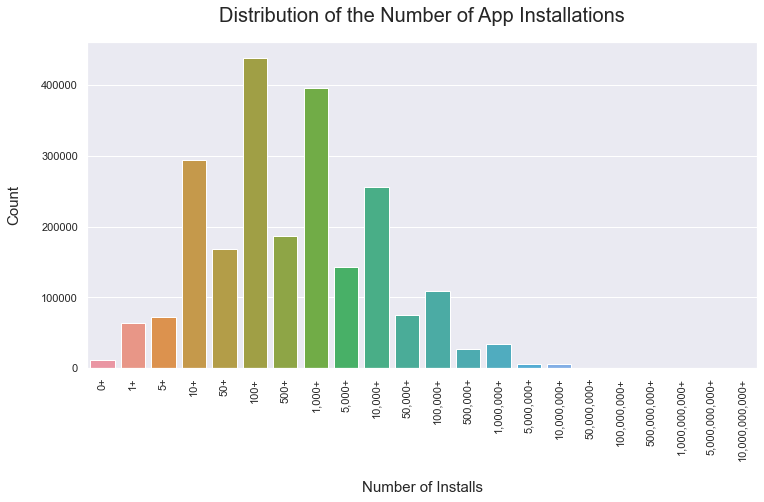

In [734]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()
sns.barplot(x='Installs', y='App Name', data=grouped_installs)
plt.xlabel('Number of Installs', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.title('Distribution of the Number of App Installations', fontsize=20, pad=20)
plt.xticks(rotation=90)
plt.show()

We suppose that (virtually) all apps have at least one install because its own developer would presumbly install it themselves for testing purposes. Although it is interesting to note that, despite the increasing interval size (we do not have access to the exact number of installs from the data), there is no evident monotonically increasing or decreasing trend. We thought that, as a consequence of the invervals increasing in size, a larger interval could "cover" more apps, so there would be an increasing trend. But we can observe that the number of apps in each 'bucket' alternates between increasing and decreasing from 5+ to 5,000,000+.

We take the average between the minimum and the maximum number of installs as "approximate installs". 

In [735]:
apps['Approx Installs'] = (apps['Minimum Installs'] + apps['Maximum Installs']) // 2

Since the dataset is large, to first visualize a scatterplot of the number of reviews against the number of installations, we wil sample the data

In [736]:
sample = apps.sample(500, random_state=35)

In [737]:
def plot_installs_and_reviews(sample, show=True):
    figure = plt.figure(figsize=(12, 6))
    axis = plt.gca()
    # From https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
    axis.ticklabel_format(style='plain')

    sns.scatterplot(x=sample['Approx Installs'], y=sample['Rating Count'], data=sample)
    plt.xlabel('Number of Installs', fontsize=15, labelpad=20)
    plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
    plt.title('Number of Reviews Against the Number of Installs for Apps', fontsize=20, pad=20)
    plt.xticks(rotation=90)

    if show: 
        plt.show()

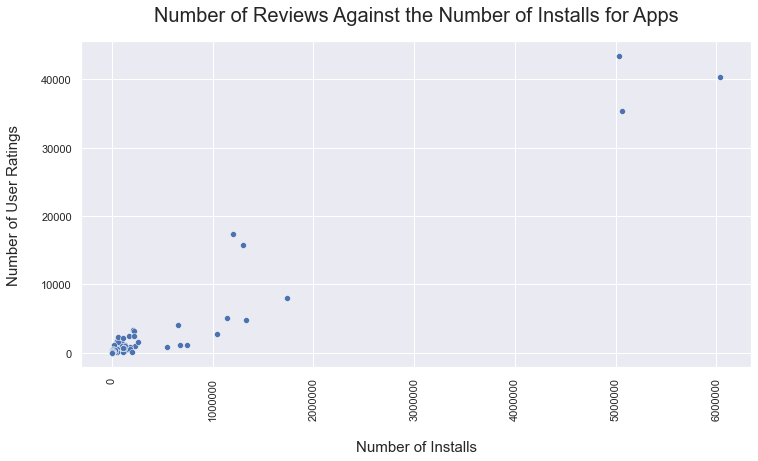

In [738]:
plot_installs_and_reviews(sample)

Visually, we can see that most of the data have less than 500000 (approx) installs. Let's consider only those data points. 

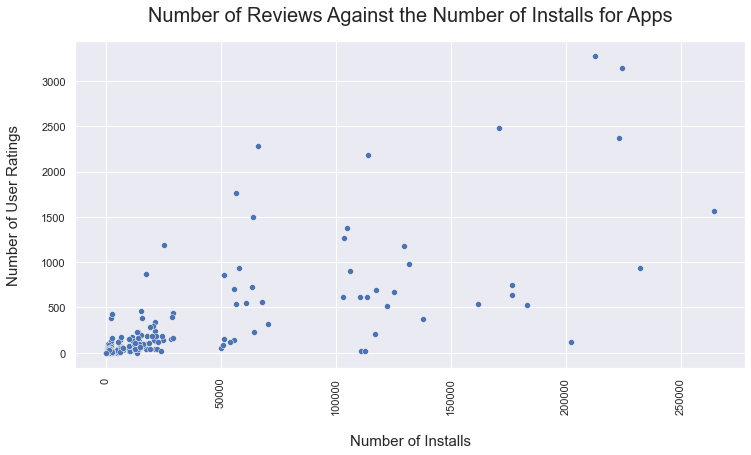

In [739]:
filtered_sample = sample[sample['Approx Installs'] < 500000]
plot_installs_and_reviews(filtered_sample)

In [740]:
fit = stats.linregress(sample['Approx Installs'], sample['Rating Count'])
sample['prediction'] = sample['Approx Installs']*fit.slope + fit.intercept

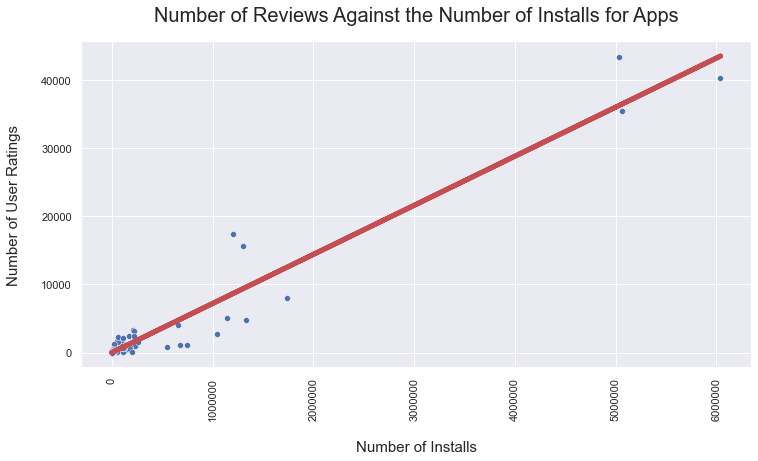

In [741]:
plot_installs_and_reviews(sample, show=False)
plt.plot('Approx Installs', 'prediction', data=sample, color='r', linewidth=5)
plt.show()

In [742]:
fit.pvalue

2.471636862792737e-306

With such a small pvalue, we can strongly reject the null hypothesis that the slope is 0 and conclude that more installs is linearly associated with more reviews. 

But what if we only consider apps with less than 1000 installs, where most of the data lie? 

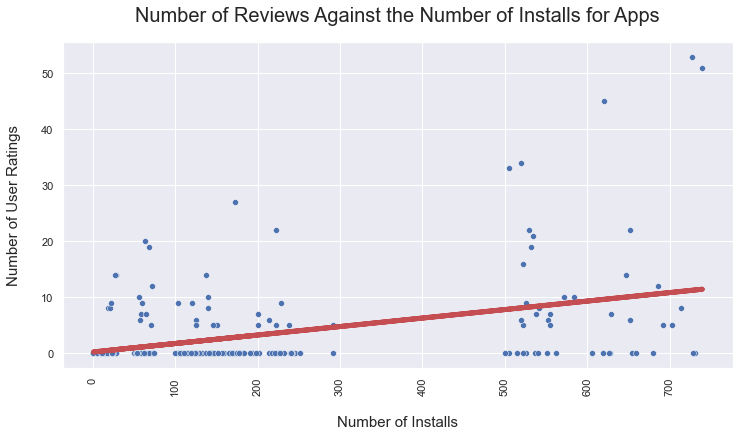

In [743]:
filtered_sample = sample[sample['Approx Installs'] < 1000].copy()
fit = stats.linregress(filtered_sample['Approx Installs'], filtered_sample['Rating Count'])
filtered_sample['prediction'] = filtered_sample['Approx Installs']*fit.slope + fit.intercept

plot_installs_and_reviews(filtered_sample, show=False)
plt.plot('Approx Installs', 'prediction', data=filtered_sample, color='r', linewidth=5)
plt.show()

In [744]:
fit.pvalue

5.590809818013023e-13

The slope is not as extreme and we get a larger pvalue. But again, even when we only consider apps that have less than a thousand reviews, we still observe a linear association between the number of installs and the number of reviews. 

Next, we return to the original data set and compute a correlation coefficient. 

In [745]:
r, p_value= stats.pearsonr(apps['Rating Count'], apps['Installations'])
r, p_value

(0.5452806023392465, 0.0)

With a p-value is 0, we know that the probability of observing the given results if the correlation coefficient was actually 0, is virtually 0. Certainly, there exists a positive linear association between the number of installs and the number of reviews. 

We proceed to investigate our next question: Are the number of app ratings increasing for newer apps?

In [746]:
apps.head()

,App Name,App Id,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,Currency,Size,Developer Id,Released,Installations,Approx Installs
0,Gakondo,com.ishakwe.gakondo,0.0,0.0,10+,10.0,15,True,0.0,USD,10M,Jean Confident Irénée NIYIZIBYOSE,"Feb 26, 2020",10,12.0
1,Ampere Battery Info,com.webserveis.batteryinfo,4.4,64.0,"5,000+",5000.0,7662,True,0.0,USD,2.9M,Webserveis,"May 21, 2020",5000,6331.0
2,Vibook,com.doantiepvien.crm,0.0,0.0,50+,50.0,58,True,0.0,USD,3.7M,Cabin Crew,"Aug 9, 2019",50,54.0
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,5.0,5.0,10+,10.0,19,True,0.0,USD,1.8M,Climate Smart Tech2,"Sep 10, 2018",10,14.0
4,GROW.me,com.horodyski.grower,0.0,0.0,100+,100.0,478,True,0.0,USD,6.2M,Rafal Milek-Horodyski,"Feb 21, 2020",100,289.0


In [748]:
pattern = re.compile('^(.*)\s\d+,\s(\d{4})$')
def extract_month_and_year(date): 
    match = pattern.match(date)
    if match: 
        return str(datetime.strptime(match[1], '%b').month) + ', ' + str(match[2])
    else:
        return np.nan 

In [749]:
apps = apps.dropna(subset=['Released'])

# Custom function to extract month and year is faster than to_datetime()
apps['Release Month/Year'] = apps['Released'].apply(lambda x: extract_month_and_year(str(x)))

# From https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns
apps[['Release Month', 'Release Year']] = apps['Release Month/Year'].str.split(',', 1, expand=True)

In [750]:
# Sort by Release Date to retain this order for subsequent aggregate
apps_test.sort_values(by=['Release Year', 'Release Month'], inplace=True)

In [751]:
grouped_dates = apps_test.groupby(by=['Release Year', 'Release Month'], sort=False)

average_rating = grouped_dates.mean('Rating').reset_index()
average_num_ratings = grouped_dates.mean('Rating Count').reset_index()

In [752]:
average_rating['Release Month'] = average_rating['Release Month'].apply(lambda x: calendar.month_abbr[int(x)])
average_num_ratings['Release Month'] = average_num_ratings['Release Month'].apply(lambda x: calendar.month_abbr[int(x)])

# Conver to a non-numeric month format for plotting
average_rating['Release Month/Year'] = average_rating['Release Month'] + average_rating['Release Year']
average_num_ratings['Release Month/Year'] = average_num_ratings['Release Month'] + average_num_ratings['Release Year']

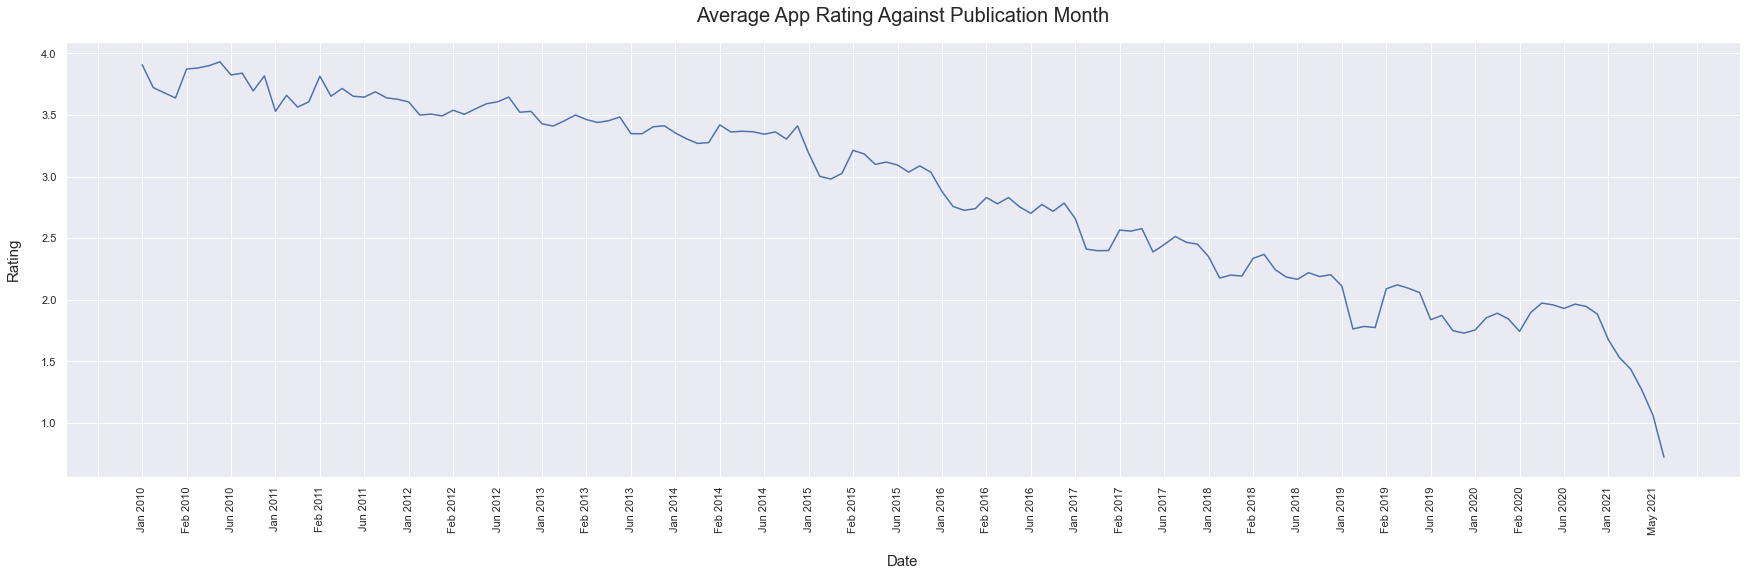

In [753]:
figure = plt.figure(figsize=(30, 8))
axis = plt.gca()
plt.plot(average_rating['Release Month/Year'], average_rating['Rating'])
plt.xlabel('Date', fontsize=15, labelpad=20)
plt.ylabel('Rating', fontsize=15, labelpad=20)
plt.xticks(rotation=90)
plt.title('Average App Rating Against Publication Month', fontsize=20, pad=20)

# From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
# Reduce the number of x-ticks
axis.xaxis.set_major_locator(plt.MaxNLocator(40))
plt.show()

In [754]:
# Need to install pymannkendall: sudo pip install pymannkendall
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install pymannkendall

We proceed to perform the Mann-Kendall Test to test for an increasing or decreasing trend in the rating of apps. 

Null hypothesis: There does not exist an increasing or decreasing trend 

Alternative hypothesis: There does exist an increasing or decreasing trend

In [755]:
# Inspired from https://pypi.org/project/pymannkendall/
import pymannkendall as mk

trend, h, pvalue, z, Tau, s, var_s, slope, intercept = mk.original_test(average_rating['Rating'])
trend, pvalue

('decreasing', 0.0)

Indubitably, from the test, we can reject the null hypothesis and conclude that there does exist a trend in the number of app ratings -- particularly an decreasing one. 

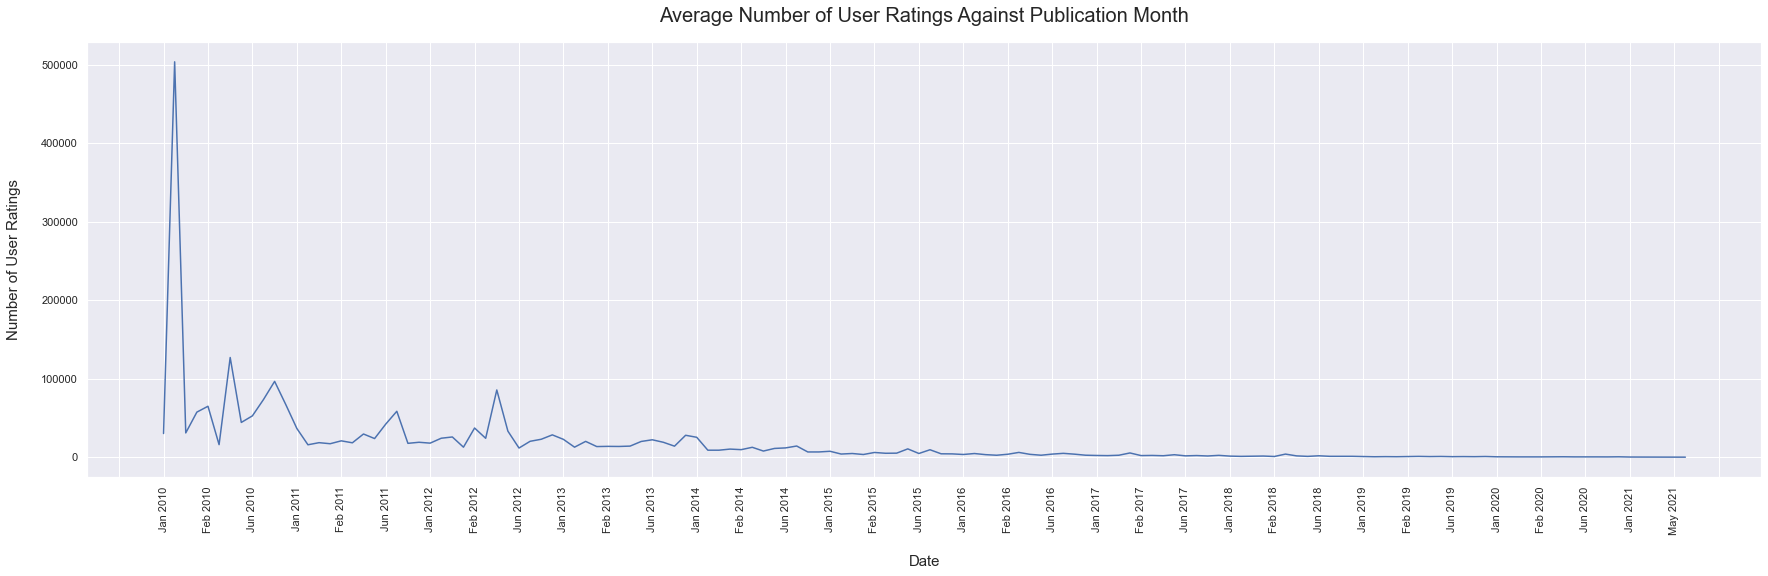

In [756]:
figure = plt.figure(figsize=(30, 8))
axis = plt.gca()
plt.plot(average_num_ratings['Release Month/Year'], average_num_ratings['Rating Count'])
plt.xlabel('Date', fontsize=15, labelpad=20)
plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
plt.xticks(rotation=90)
plt.title('Average Number of User Ratings Against Publication Month', fontsize=20, pad=20)

# From https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
# Reduce the number of x-ticks
axis.xaxis.set_major_locator(plt.MaxNLocator(40))
plt.show()

Apps published in early 2010 have an unusally large number of user ratings. Let's investigate that data point. 

In [757]:
high_num_rating = average_num_ratings.iloc[average_num_ratings['Rating Count'].idxmax()]
high_num_rating_month = str(datetime.strptime(high_num_rating['Release Month'], '%b').month)
high_num_rating_year = int(high_num_rating['Release Year'].strip())

apps_test['Release Year'] = apps_test['Release Year'].astype(int)
high_num_rating_apps = apps_test[(apps_test['Release Month'] == high_num_rating_month) &
                                 (apps_test['Release Year'] == high_num_rating_year)].copy()

In [758]:
high_num_rating_apps.sort_values(by=['Rating Count'], ascending=False, inplace=True)
top_ten = high_num_rating_apps.head(5)

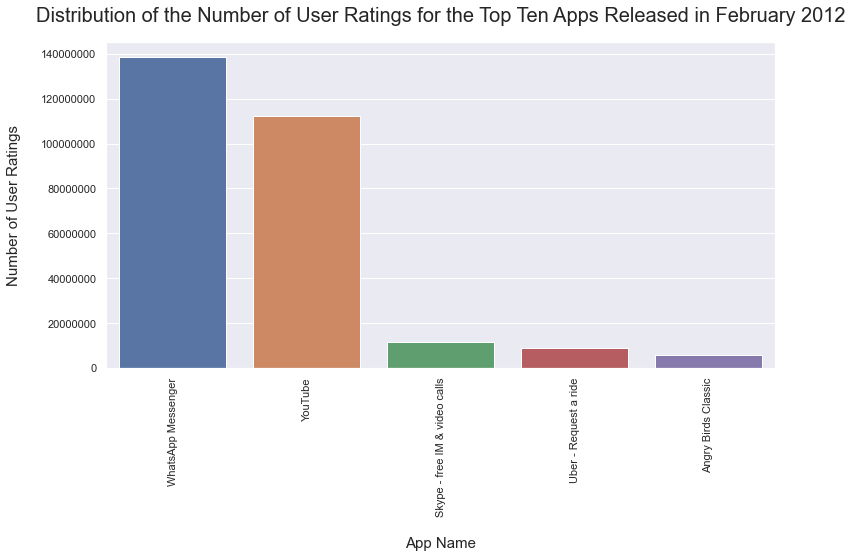

In [759]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

# From https://stackoverflow.com/questions/28371674/prevent-scientific-notation-in-matplotlib-pyplot
axis.ticklabel_format(style='plain')

sns.barplot(x='App Name', y='Rating Count', data=top_ten)
plt.xticks(rotation=90)
plt.xlabel('App Name', fontsize=15, labelpad=20)
plt.ylabel('Number of User Ratings', fontsize=15, labelpad=20)
plt.title('Distribution of the Number of User Ratings for the Top Ten Apps Released in February 2012', fontsize=20, pad=20)
plt.show()

We can see that the usually large mean number of user ratings in the February of 2012 is attributed to two particular apps: WhatsApp and YouTube.
    
Next, in addition to analyzing if the number of user ratings increase over time, we will investigate if this is true for each developer: do the number of user ratings increase over time for apps published by the same developer?

In [792]:
grouped_apps = apps_test.groupby(by=['Developer Id']).count()

In [793]:
# Only include developers who have published more than 50 apps (If a developer does not publish many apps, it is not worth investigating)
grouped_apps = grouped_apps[grouped_apps['App Id'] > 50]
grouped_apps = grouped_apps.reset_index()

In [794]:
apps_test = apps_test.merge(right=grouped_apps['Developer Id'])
apps_test['Released'] = pd.to_datetime(apps_test['Released']).dt.date
apps_test.sort_values(by=['Released'], inplace=True)

In [795]:
# Custom aggregate to reverse-explode (implode) 
# Column 1  Column 2       Column 1     Column 2
#   a          6            a            [6, 7]
#   a          7       =>   b              [8] 
#   b          8

def implode(series): 
    return series.to_list()

In [796]:
imploded_apps = apps_test.groupby('Developer Id', sort=False).agg({'Rating Count': [implode], 'Released': [implode]})
imploded_apps.reset_index(inplace=True)
imploded_apps.head()

,Developer Id,Rating Count,Released
,,implode,implode
0,SeeClickFix,"[1428.0, 111.0, 197.0, 62.0, 133.0, 6.0, 9.0, ...","[2010-02-04, 2012-07-17, 2012-10-26, 2013-01-2..."
1,Kittehface Software,"[61.0, 69427.0, 7496.0, 8859.0, 1358.0, 167295...","[2010-02-10, 2010-03-18, 2010-03-18, 2010-03-2..."
2,SpeedyMarks,"[27.0, 61.0, 53.0, 70.0, 37.0, 22.0, 45.0, 94....","[2010-02-11, 2010-02-12, 2010-03-02, 2010-03-1..."
3,Monotype Imaging Inc.,"[246.0, 501.0, 358.0, 241.0, 671.0, 370.0, 144...","[2010-02-17, 2010-05-21, 2010-05-26, 2010-05-2..."
4,Google LLC,"[601272.0, 19798962.0, 2311151.0, 9488421.0, 7...","[2010-02-22, 2010-08-12, 2010-09-09, 2010-09-2..."


In [797]:
# Need to install pymannkendall: sudo pip install pymannkendall
# From https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install pymannkendall

We proceed to perform the Mann-Kendall Test to test for an increasing or decreasing trend in the number of user ratings for each developer. 

Null hypothesis: There does not exist an increasing or decreasing trend.

Alternative hypothesis: There does exist an increasing or decreasing trend.

In [815]:
# Inspired from https://pypi.org/project/pymannkendall/
def test_mannkendall(ratings):
    
    trend, h, pvalue, z, Tau, s, var_s, slope, intercept = mk.original_test(ratings)
    return str(trend) + ', ' + str(pvalue)

In [816]:
imploded_apps['test_res'] = imploded_apps['Rating Count']['implode'].apply(lambda x: test_mannkendall(x))

,Developer Id,Rating Count,Released,pvalue,test_res
,,implode,implode,,
0,SeeClickFix,"[1428.0, 111.0, 197.0, 62.0, 133.0, 6.0, 9.0, ...","[2010-02-04, 2012-07-17, 2012-10-26, 2013-01-2...",1.388014e-10,"decreasing, 1.3880141480626662e-10"
1,Kittehface Software,"[61.0, 69427.0, 7496.0, 8859.0, 1358.0, 167295...","[2010-02-10, 2010-03-18, 2010-03-18, 2010-03-2...",5.319937e-07,"decreasing, 5.319936686731808e-07"
2,SpeedyMarks,"[27.0, 61.0, 53.0, 70.0, 37.0, 22.0, 45.0, 94....","[2010-02-11, 2010-02-12, 2010-03-02, 2010-03-1...",6.207395e-04,"decreasing, 0.0006207395160970908"
3,Monotype Imaging Inc.,"[246.0, 501.0, 358.0, 241.0, 671.0, 370.0, 144...","[2010-02-17, 2010-05-21, 2010-05-26, 2010-05-2...",2.901683e-10,"decreasing, 2.9016833380524076e-10"
4,Google LLC,"[601272.0, 19798962.0, 2311151.0, 9488421.0, 7...","[2010-02-22, 2010-08-12, 2010-09-09, 2010-09-2...",2.156275e-12,"decreasing, 2.156275158426979e-12"
...,...,...,...,...,...
3863,jamal helal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2021-04-07, 2021-04-11, 2021-04-11, 2021-04-1...",1.068085e-01,"no trend, 0.1068084909778535"
3864,"pentagram, inc.","[41.0, 32.0, 0.0, 0.0, 25.0, 0.0, 23.0, 6.0, 1...","[2021-04-09, 2021-04-13, 2021-04-13, 2021-04-1...",8.464904e-04,"decreasing, 0.0008464903560905235"
3865,Quran Majed Full Offline,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2021-04-09, 2021-04-09, 2021-04-09, 2021-04-0...",1.615009e-01,"no trend, 0.1615008964419693"


In [818]:
# From https://stackoverflow.com/questions/14745022/how-to-split-a-dataframe-string-column-into-two-columns
imploded_apps[['trend', 'pvalue']] = imploded_apps['test_res'][.str.split(',', 1, expand=True)

,Developer Id,Rating Count,Released,pvalue,test_res,trend
,,implode,implode,,,
0,SeeClickFix,"[1428.0, 111.0, 197.0, 62.0, 133.0, 6.0, 9.0, ...","[2010-02-04, 2012-07-17, 2012-10-26, 2013-01-2...",1.3880141480626662e-10,"decreasing, 1.3880141480626662e-10",decreasing
1,Kittehface Software,"[61.0, 69427.0, 7496.0, 8859.0, 1358.0, 167295...","[2010-02-10, 2010-03-18, 2010-03-18, 2010-03-2...",5.319936686731808e-07,"decreasing, 5.319936686731808e-07",decreasing
2,SpeedyMarks,"[27.0, 61.0, 53.0, 70.0, 37.0, 22.0, 45.0, 94....","[2010-02-11, 2010-02-12, 2010-03-02, 2010-03-1...",0.0006207395160970908,"decreasing, 0.0006207395160970908",decreasing
3,Monotype Imaging Inc.,"[246.0, 501.0, 358.0, 241.0, 671.0, 370.0, 144...","[2010-02-17, 2010-05-21, 2010-05-26, 2010-05-2...",2.9016833380524076e-10,"decreasing, 2.9016833380524076e-10",decreasing
4,Google LLC,"[601272.0, 19798962.0, 2311151.0, 9488421.0, 7...","[2010-02-22, 2010-08-12, 2010-09-09, 2010-09-2...",2.156275158426979e-12,"decreasing, 2.156275158426979e-12",decreasing
...,...,...,...,...,...,...
3863,jamal helal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2021-04-07, 2021-04-11, 2021-04-11, 2021-04-1...",0.1068084909778535,"no trend, 0.1068084909778535",no trend
3864,"pentagram, inc.","[41.0, 32.0, 0.0, 0.0, 25.0, 0.0, 23.0, 6.0, 1...","[2021-04-09, 2021-04-13, 2021-04-13, 2021-04-1...",0.0008464903560905235,"decreasing, 0.0008464903560905235",decreasing
3865,Quran Majed Full Offline,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2021-04-09, 2021-04-09, 2021-04-09, 2021-04-0...",0.1615008964419693,"no trend, 0.1615008964419693",no trend


In [837]:
imploded_apps['pvalue'] = imploded_apps['pvalue'].astype(float)
significant_apps = imploded_apps[imploded_apps['pvalue'] < 0.05] 

In [821]:
len(significant_apps)

2091

In [822]:
len(imploded_apps) - len(significant_apps)

1777

In [803]:
len(significant_apps) / len(imploded_apps)

0.5405894519131335

This is the proportion of developers considered that exhibit a stastically significant trend in their app review counts. 

Let's compare the number apps that have an increasing trend against against ones that have a decreasing trend. 

In [827]:
decreasing_trend_apps = imploded_apps[imploded_apps['trend'] == 'decreasing'] 
increasing_trend_apps = imploded_apps[imploded_apps['trend'] == 'increasing']
len(decreasing_trend_apps), len(increasing_trend_apps)

(1979, 112)

It seems that most apps that exhibit a statistically significant trend in the number of app ratings have a negative trend. 

In [828]:
significant_apps.set_index('Developer Id', inplace=True)

##### Plotting the number of game ratings against publication date for developers that exhibit a statistically significant trend. Added a dropdown widget to toggle between different developers. 

In [829]:
def plot_trend(developer): 
    figure = plt.figure(figsize=(12,6))
    developer_info = significant_apps.loc[developer]

    dates = developer_info['Released']['implode']
    ratings = developer_info['Rating Count']['implode']
    axis = plt.gca()
    
    plt.plot(dates, ratings, linewidth=5)
    plt.xlabel('Date Published', fontsize=18, labelpad=40)
    plt.ylabel('Number of User Ratings', fontsize=18, labelpad=40)
    plt.xticks(rotation=90)
    plt.title('Developer: ' + developer + ' (Number of Game Ratings Against Publication date)', fontsize=25, pad=40)
    
    # From https://stackoverflow.com/questions/2969867/how-do-i-add-space-between-the-ticklabels-and-the-axes-in-matplotlib
    axis.tick_params(axis='x', which='major', pad=15, labelsize=15)
    axis.tick_params(axis='y', which='major', pad=15, labelsize=15)    
    plt.show()


In [830]:
dropdown = widgets.Dropdown(
    options=significant_apps.index,
    value=significant_apps.index[0], # Index stores all the developers
    description='Select a Developer: ',
    style={'description_width': 'initial'}
)

In [831]:
# Inspired from https://github.com/jupyter-widgets/ipywidgets/issues/2148
output = widgets.Output()

@output.capture()
def on_dropdown_change(change_info):
    output.clear_output()
    selected_developer = change_info['new']
    plot_trend(selected_developer)

In [832]:
# Plot the first item in the dropdown as default
with output: 
    plot_trend(significant_apps.index[0])

In [833]:
dropdown.observe(on_dropdown_change, names='value')

## Interactive Dropdown (run the code to use) 

In [834]:
display(dropdown)
display(output)

Dropdown(description='Select a Developer: ', options=('SeeClickFix', 'Kittehface Software', 'SpeedyMarks', 'Mo…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 864x432 with 1 Axes>', 'i…

## Remarks

Feel free to experiment with the dropdown menu to check out the trends in the number of game ratings for different developers.

It appears that most of trends that are statistically significant are decreasing, which is unexpected. However, we must also note that games published earlier have existed for longer and thus, had more time for users to generate ratings. We also acknowledgement the limitiation in the amount of data -- most developers do not publish many applications. 

